In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from read_roi import read_roi_zip
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import untangle
from sklearn.linear_model import LinearRegression
import sys, os
sys.path.insert(0, os.path.abspath('../utils'))
from MastodonFunctions_ import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# Figure 1 C: In vivo Mesp and Her 1 data

<a id='top'></a>

In this notebook we create the Kymographs for Figure 1 using an entire tracked somite in a Looping (Her1-YFP) embryo and in a Heidi (Mesp-ba-mKate) embryo. These cells start in the most anterior PSM where they eventually form a somite (S1). Posterior boundary of S1 formed at timepoint 50 (75 min) and the anterior boundary of S0 formed at timepoint 25 (37.5 min).

[1] [Mesp Kymograph](#MespK): The movie was backtracked from timepoint 60 (90 mins) until timepoint 0 (0 mins). 

[2] [Looping Kymograph](#LoopK): The movie was back tracked form timepoint 75 (112.5 min) until timepoint 10 (15 min). These cells start in the most anterior PSM where they eventually form a somite (S1). Posterior boundary of S1 formed at timepoint 60 (90 min) and the anterior boundary of S0 formed at timepoint 35 (52.5 min).

## Mesp Data
<a id='MespK'></a>

Import *in vivo* data from tracked cells going from Somite -I, 0, I. Cell tracks were obtained using Mastodon (from Fiji) and all the cells tracked belong to the same somite. 

In [2]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1, 2]

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure 1/Figure 1F-I/Mesp Data/Position1_20191031.xml', '../Data/Figure 1/Figure 1F-I/Mesp Data/Position2_20191031.xml' ]  # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure 1/Figure 1F-I/Mesp Data/Position1', '../Data/Figure 1/Figure 1F-I/Mesp Data/Position2']

# Path to zip were all the ROIs from the somites are
path_roi = ['../Data/Figure 1/Figure 1F-I/Mesp Data/RoiSet-Position1.zip', '../Data/Figure 1/Figure 1F-I/Mesp Data/RoiSet-Position2.zip']

### Image characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes


for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 239 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 239 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [5]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])

In [6]:
print('Position 1 has %d cells'%tracks1.n_tracks_divs)
print('Position 2 has %d cells'%tracks2.n_tracks_divs)

Position 1 has 190 cells
Position 2 has 217 cells


## Spatial Analysis - ROI parallel to notochord

In [7]:
position = 0

# One ROI per timepoint
rois = read_roi_zip(path_roi[position])
time_points = len(rois)

In [8]:
spots = csv_features(path_csv[position], path_xml[position])
    
# Order the time series according to each individual cell
tracks = ordering_tracks(path_csv[position], path_xml[position])

In [9]:
print('Number of cells: %d'%tracks.n_tracks_divs)

Number of cells: 190


### Plot the traces

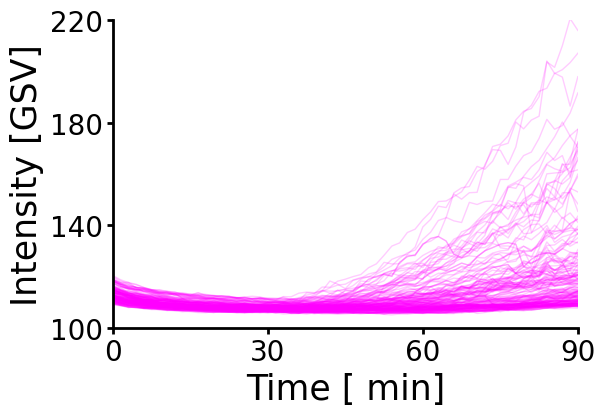

In [10]:
fig = plt.figure(figsize=[6,4])
for i in range(tracks.n_tracks_divs):
    plt.plot(tracks.spots_features['Frames'][i], tracks.spots_features['Mean2'][i], linewidth=1, color='magenta', alpha=0.2)
plt.xlabel('Time [ min]', fontsize=25)
plt.ylabel('Intensity [GSV]', fontsize=25)
plt.yticks(np.arange(100,240,40),fontsize=20)
plt.xticks(np.arange(0,80,20), map(int,np.arange(0,80,20)*tr_min), fontsize=20)
plt.ylim([100,220])
plt.xlim([0,60])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

### Calculate Mesp Onset

#### Mesp Increase analysis

In [11]:
# How many points to take into account for the average of Area 1 and 2

def ratio_mesp(window, intensities):
    # Compute the areas
    area1 = np.mean(intensities[:window])
    area2 = np.mean(intensities[-window:])

    # Compute the ratio
    ratio = area2 - area1
    
    return ratio

# Compute the ratio: Area 2 / Area 1 
ratio1 = []
ratio2 = []
ratio3 = []

intensities_all = []
frames_all = []

# Join both embryos to analyze them as 1 experiment
j = position
    
intensities_aux = eval('tracks%d.spots_features["Mean2"]'%(j+1))
frames_aux = eval('tracks%d.spots_features["Frames"]'%(j+1))

for i in range(len(intensities_aux)):

    # Intensity values of Mesp tracks: +8 because the first 8 timepoints are slightly brigher
    intensities = intensities_aux[i][8:]
    frames = frames_aux[i][8:]

    if intensities.size>0:
        ratio1.append(ratio_mesp(5, intensities))
        ratio2.append(ratio_mesp(10, intensities))
        ratio3.append(ratio_mesp(15, intensities))

        intensities_all.append(intensities)
        frames_all.append(frames)
    

### Area 1 and Area 2 plots

These areas are the ones used to calculate the Mesp Fold Change. We define this window where we will get all intensity values from all those traces during those window timepoints and we will perform the average. Then for the Mesp Fold Change we will compare these two areas with their respective average intensities. 

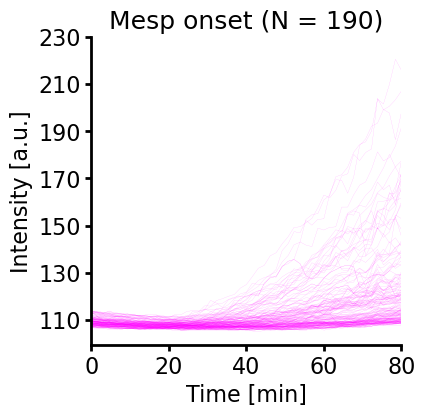

In [12]:
plt.figure(figsize=[4,4])

offset = 8
window = 5

for i in range(len(intensities_all)):
    plt.plot(frames_all[i], intensities_all[i], alpha=0.5, color='magenta', linewidth=0.1)


plt.xlabel('Time [min]',fontsize=16)
plt.xticks(np.linspace(8,90/tr_min,5), np.linspace(0,80,5, dtype=int), fontsize=16)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190,210,230],fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
plt.title('Mesp onset (N = %d)'%(len(intensities_all)), fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

## Clustering 
### Determine number of clusters with the elbow method

When K increases, the centroids are closer to the clusters centroids.
The improvements will decline, at some point rapidly, creating the elbow shape.
Check this [link](https://pythonprogramminglanguage.com/kmeans-elbow-method/) for more information about this method.

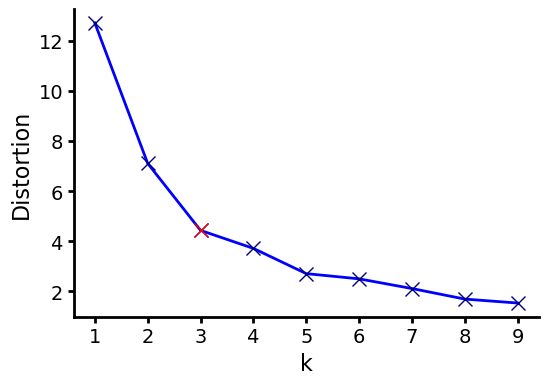

In [13]:
# k means determine k: ELBOW METHOD
window = 5


plt.figure(figsize=[6,4])

    
distortions = []
K = range(1,10)

# Define the data
X = np.array(ratio1).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=100).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2, markersize=10,  mec='navy')
plt.plot(3, distortions[2], 'bx-', linewidth=6, markersize=10,  mec='red')

plt.xlabel('k', fontsize=16)
plt.ylabel('Distortion', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('The Elbow Method showing the optimal k', fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

### K-Means Classification

Using a cluster size of 3, we will classify the distribution that we obtained for the Mesp onset fold change. 

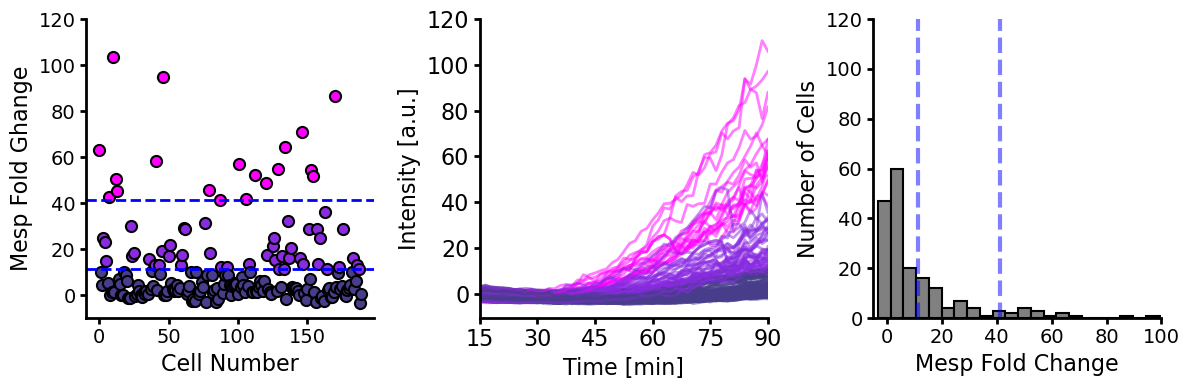

In [14]:
# Distributions

plt.figure(figsize=[12,4])

plt.subplot(131)
# Calculate the percentage of Mesp on cells

# Remove nans
ratio1_ = np.array(ratio1)
inds = np.where(np.isnan(ratio1_))[0]

if np.isnan(np.sum(ratio1_)):
    ratio1_ = ratio1_[~np.isnan(ratio1_)]
    
#color = ['navy', 'deepskyblue', 'royalblue', 'aqua']
color = ['blueviolet','magenta','darkslateblue']#'mediumorchid']

# Use the same seed to avoid changing clusters 
# Define the data
X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred1 = KMeans(n_clusters=3, n_init=200, random_state=1).fit_predict(X)

group1 = np.where(y_pred1==1)[0]
group2 = np.where(y_pred1==2)[0]
group3 = np.where(y_pred1==0)[0]

val1 = np.min(ratio1_[group1])
val2 = np.min(ratio1_[group3])


for i in range(len(X)):
    plt.plot(i, X[i], 'o', markersize=8, markerfacecolor=color[y_pred1[i]], markeredgewidth=1.5, markeredgecolor='black')

plt.axhline(val1, color='blue', linewidth=2, linestyle='--')
plt.axhline(val2, color='blue', linewidth=2, linestyle='--')

plt.xlabel('Cell Number', fontsize=16)
plt.ylabel('Mesp Fold Ghange', fontsize=16)
plt.ylim([-10,120])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(132)
count = 0
for i in range(len(intensities_all)):   
    if all(i != inds):
        plt.plot(frames_all[i], intensities_all[i]-110, c=color[y_pred1[count]],alpha=0.5, linewidth=2)    
        count +=1 
plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr/60)), fontsize=16)
plt.xlim([10,60])
plt.yticks(np.arange(0,140,20),fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(133)

plt.hist(ratio1_, color='grey', edgecolor='black', bins='fd', linewidth=1.5)
plt.axvline(val1, color='blue', linewidth=3, alpha=0.5, linestyle='dashed')
plt.axvline(val2, color='blue', linewidth=3, alpha=0.5, linestyle='dashed')

plt.xlabel('Mesp Fold Change', fontsize=16)
plt.ylabel('Number of Cells', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-5,100])
plt.ylim([0,120])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

### In cells with high Mesp values, when is this happening?

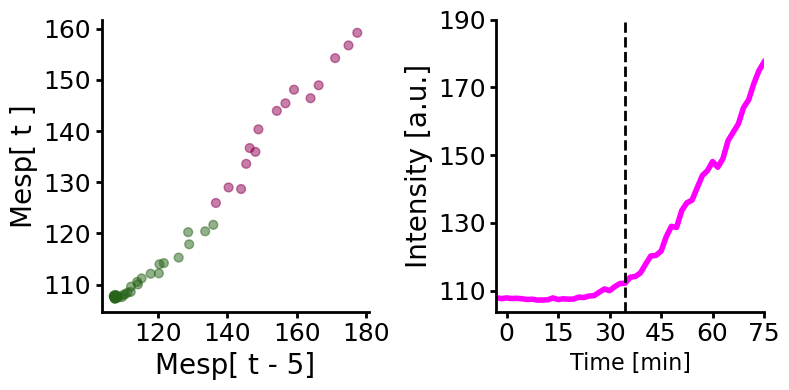

In [15]:
i = np.where(y_pred1==1)[0][0]

window = 5

X = np.zeros((len(intensities_all[i][window:]),2))
X[:,0] = intensities_all[i][window:]
X[:,1] = intensities_all[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=0.5,cmap='PiYG',s=40)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=20)
plt.ylabel('Mesp[ t ]', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(frames_all[i], intensities_all[i], color='magenta', linewidth=4)
plt.axvline(ind_cut[0], color='black', linewidth=2, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round((locs-10)*tr/60)), fontsize=18)
plt.xlim([8,60])
plt.yticks([110,130,150,170,190],fontsize=18)
plt.ylabel('Intensity [a.u.]',fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

In [16]:
# Apply to all the cells with Mesp on
n_clusters = 3

X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio1_[np.where(y_pred==0)[0]])
max2 = np.max(ratio1_[np.where(y_pred==1)[0]])
max3 = np.max(ratio1_[np.where(y_pred==2)[0]])

# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[1:]

# Find the positions where those values are in the ratio
ind_mesp = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))


onset_mesp_s1 = []
onset_mesp_frames = []
ind_mesp_frames = []
window = 5
max_mesp = []

aux = []

#for i in range(len(intensities_all)):
for i in ind_mesp:    
    if any(np.isnan(intensities_all[i])):
        continue
    else:
        X = np.zeros((len(intensities_all[i][window:]),2))
        X[:,0] = intensities_all[i][window:]
        X[:,1] = intensities_all[i][:-window]
        y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

        ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
        onset_mesp = ind_cut[0]
        
        # Mesp Onset starting from the first frame cells were tracked (frame = 0)
        onset_mesp_s1.append((onset_mesp+8)*tr_min)
        onset_mesp_frames.append(8+onset_mesp)
        ind_mesp_frames.append(i)
        max_mesp.append(np.max(intensities_all[i]))


# For plotting later in the kymograph
onset_mesp_k = np.zeros((tracks.n_tracks_divs, fts.n_frames))
onset_mesp_k[np.array(ind_mesp_frames), np.array(onset_mesp_frames)] = 1

### Plot Mesp Onset Distribution

#### Example Mesp Onset

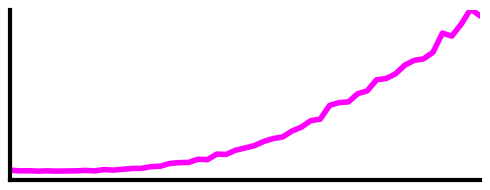

In [17]:
fig = plt.figure(figsize=[5,2])


i = 10
plt.plot(frames_all[i]*tr_min, intensities_all[i], color='magenta', alpha=1, linewidth=4)

#plt.axvline(50, color='black', linestyle='dashed', linewidth=2)
plt.xticks([])
plt.yticks([])
#plt.ylabel('Mesp-ba-mKate2\nIntensity [GSV]', fontsize=25)
#plt.xlabel('Time [min]', fontsize=25)
plt.ylim([100,220])
plt.xlim([15,90])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1F-I/Results/MesopSomite-Traces-LastPeak-Example.pdf', bbox_inches='tight')

#### Single cells Mesp Onsets: For cells we classify which have Mesp ON only

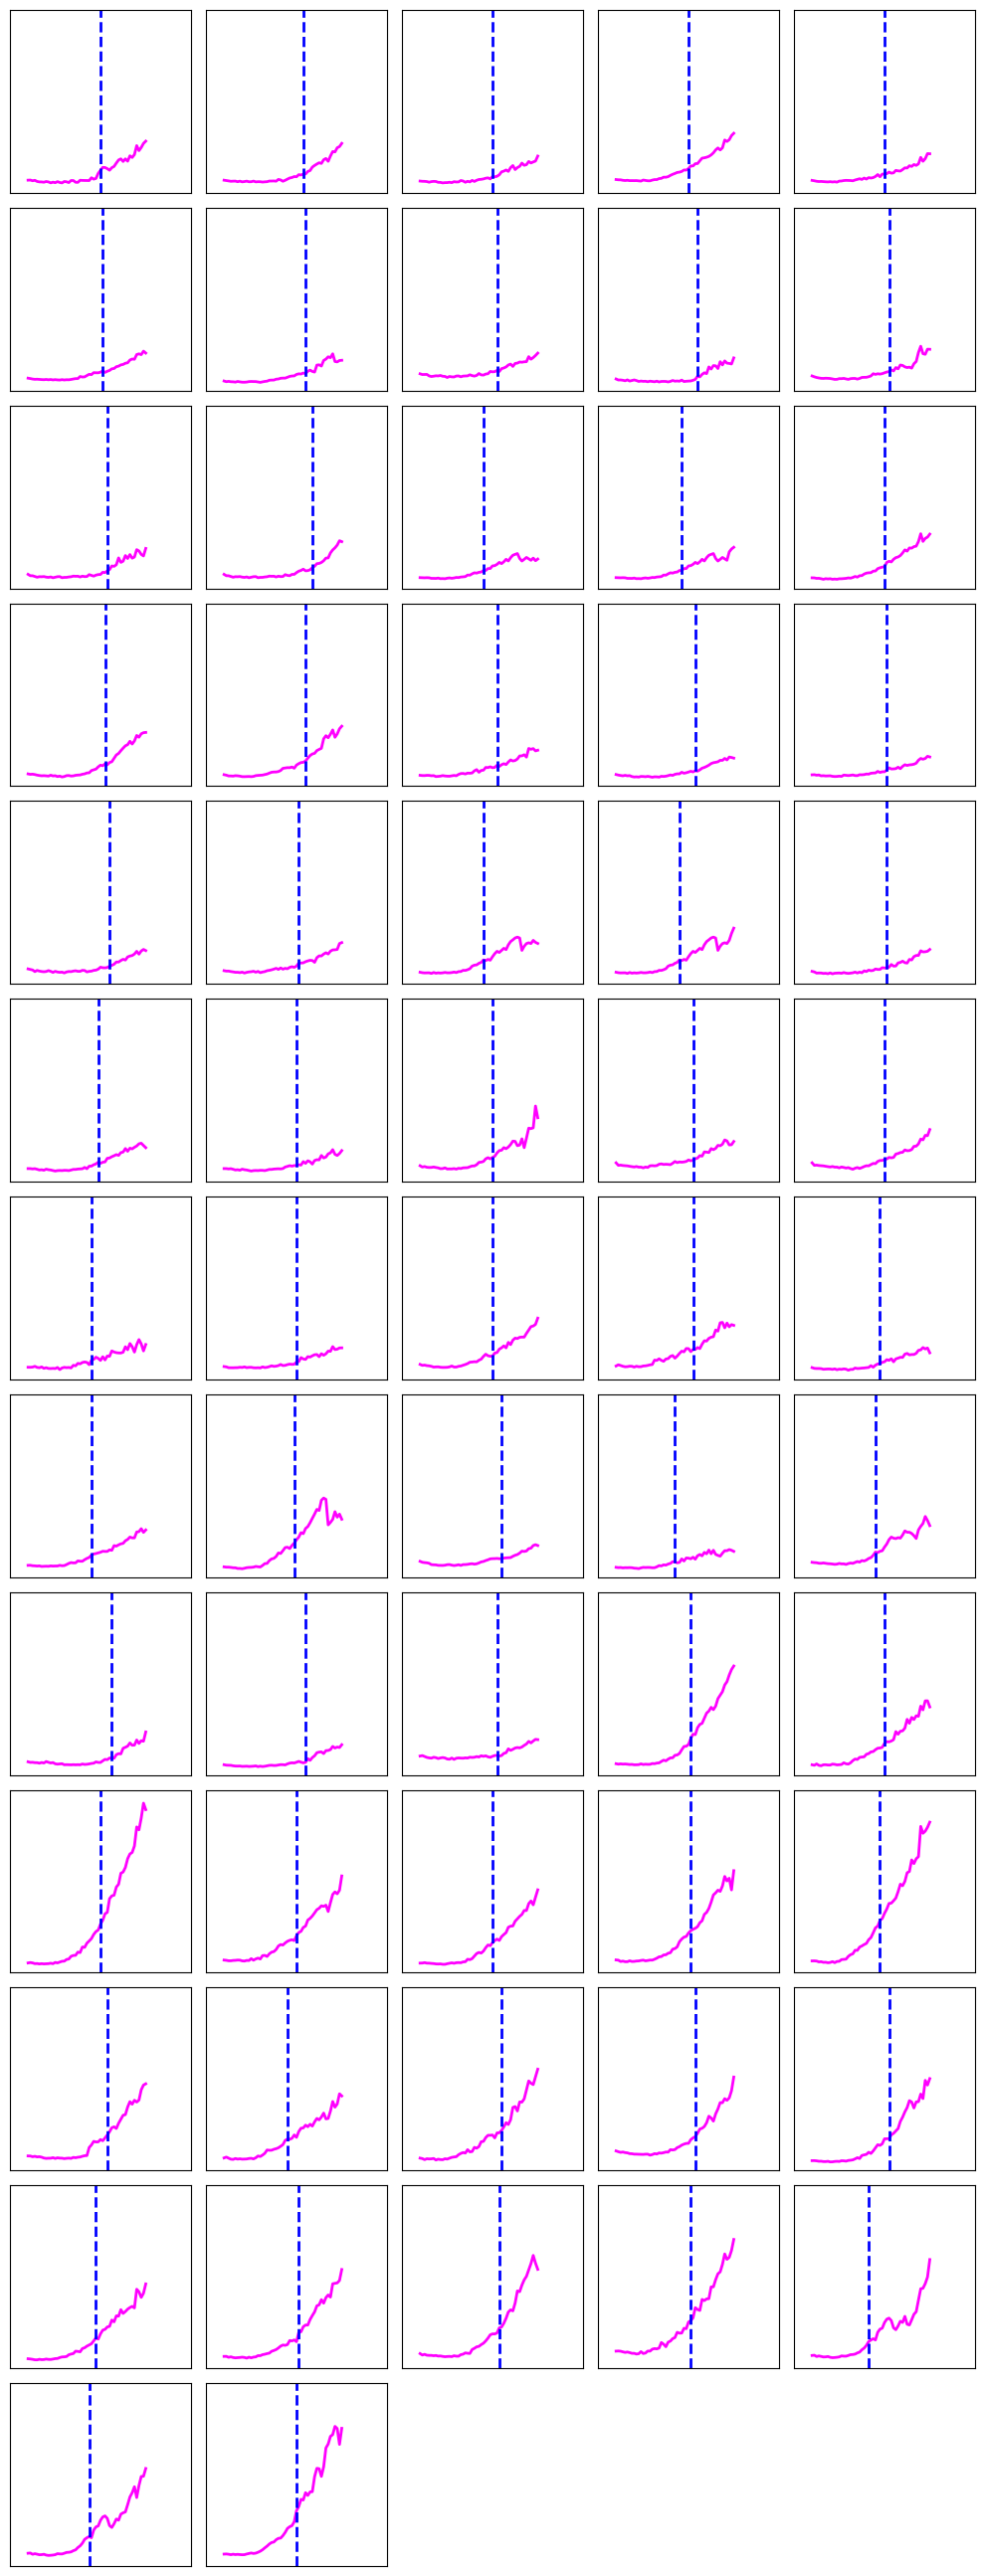

In [18]:
lag_window = 5
color = ['navy', 'deepskyblue', 'royalblue', 'aqua']

# Define the dimensions of the subplot
n_cols =  5
n_cells = len(onset_mesp_s1)
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_fig = n_rows*(10/n_cols)
fig = plt.figure(figsize=[10,size_fig])

count = 0
for i in ind_mesp:
    if any(np.isnan(intensities_all[i])):
        continue
    else:
    
        # Update the number of subplots    
        ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
        plot_num += 1

        plt.plot(frames_all[i], intensities_all[i], color='magenta', linewidth=2)
        plt.axvline(onset_mesp_s1[count]/tr_min, color='blue', linestyle='dashed', linewidth=2)
        count +=1
        plt.xticks([])
        plt.xlim([0,80])
        plt.ylim([100,230])
        plt.yticks([])
    
plt.tight_layout()
plt.show()

### Data Arrangements for Mesp Kymographs

### Mesp Onset Kymograph

In [19]:
path_roi = '../Data/Figure 1/Figure 1F-I/Mesp Data/RoiSet-Position1-Notochord.zip' 

In [20]:
# Read all the ROIs
rois = read_roi_zip(path_roi)

# Number of timepoints
time_points = len(rois)

# Number of points in each segmented notochord line
notochord_points = 32

# Name of ROIs per time point
name_rois = list(rois.keys())

# Initialize where to save the coordinates
x_coords_not = np.zeros((time_points, notochord_points))
y_coords_not = np.zeros((time_points, notochord_points))

for j in range(len(rois)):

    # To know in which frame the analysis happened
    frame = int(rois[name_rois[j]]['name'][:4])
    
    if len(rois[name_rois[j]]['x'])==32:
        x_coords_not[frame,:] = rois[name_rois[j]]['x']
        y_coords_not[frame,:] = rois[name_rois[j]]['y']
    else:
        x_coords_not[frame,:] = rois[name_rois[j]]['x'][:-1]
        y_coords_not[frame,:] = rois[name_rois[j]]['y'][:-1]

#### Re-arrange the data 

In [21]:
n_cells = tracks.n_tracks_divs

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((n_cells, fts.n_frames+1))*np.nan
last_peaks_save = np.zeros((n_cells, fts.n_frames+1))
    

# Save also the x,y positions
x_save = np.ones((n_cells, fts.n_frames+1))*np.nan
y_save = np.ones((n_cells, fts.n_frames+1))*np.nan
z_save = np.ones((n_cells, fts.n_frames+1))*np.nan

# For each track 
for i in range(n_cells):
    frames = tracks.spots_features['Frames'][i]
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames):
        tracks_save[i,val] = tracks.spots_features['Mean2'][i][j]
        x_save[i,val] = tracks.spots_features['X'][i][j]
        y_save[i,val] = tracks.spots_features['Y'][i][j]
        z_save[i,val] = tracks.spots_features['Z'][i][j]

#### Equidistant points to increase spatial resolution

In [22]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
n_points = 20 # Number of points to add 

for i in range(time_points):
    
    
    # Initial number of points from fiji
    x = x_coords_not[i].astype(int)
    y = y_coords_not[i].astype(int)
    
    x_aux = []
    y_aux = []
    
    for j in range(notochord_points-1):
        aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))
        
        # For each of the inserted points
        for k in range(len(aux)-1):
            x_aux.append(aux[k][0])
            y_aux.append(aux[k][1])
            
    x_not_equidist.append(x_aux)
    y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 252
Number of points per timepoint: 620


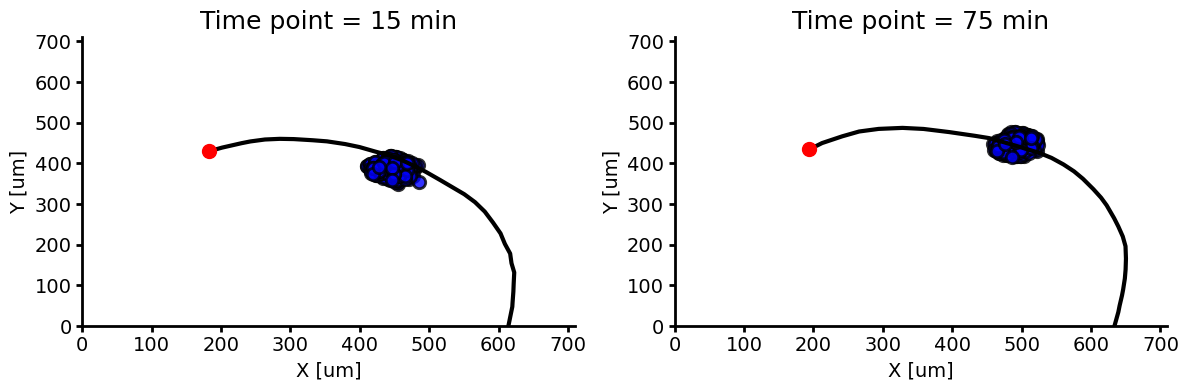

In [23]:
plt.figure(figsize=[12,4])
plt.subplot(121)
tp = 10
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save[j][tp],y_save[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.subplot(122)
tp = 50
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
     plt.scatter(x_save[j][tp],y_save[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

#### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [24]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return distance_to_ref

In [25]:
# Project the rest of the cells
proj_dist_all = []

# For each cell tracked
for i in range(n_cells):
    
    distance = []
    frames = tracks.spots_features['Frames'][i]
    
    # For each of the timepoints
    for j in frames:
        
        # Find the projected value
        distance.append(projectionNotochord(x_save[i][j], y_save[i][j],\
                                np.array(x_not_equidist[j])*fts.x_pixel, \
                                            np.array(y_not_equidist[j])*fts.x_pixel))

    proj_dist_all.append(distance)
    
# Because they all have different sizes, make them all have the same length for simplicity for later computations
proj_save = np.ones((n_cells, fts.n_frames+1))*np.nan
# For each track 
for i in range(n_cells):
    frames = tracks.spots_features['Frames'][i]
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames):
        proj_save[i,val] = proj_dist_all[i][j]

#### Arrange according to timepoints

In [26]:
position = []
intensity = []

for i in range(fts.n_frames):
    aux1 = []
    aux2 = []
    
    for j in range(n_cells):
        # For each timepoint, get allt he cells in that timepoint: the distance of the projection
        # and the intensity for that position
        aux1.append(proj_save[j,i])
        aux2.append(onset_mesp_k[j,i])
    
    # Organize the distances according to which is more posterior (e.g. smaller)
    inds = np.argsort(aux1)
    position.append(np.array(aux1)[inds])
    intensity.append(np.array(aux2)[inds])

#### Create de grid

In [27]:
min_dist = np.nanmin(position)
max_dist = np.nanmax(position)

N = 50
space = np.linspace(min_dist, max_dist, N)
time = np.arange(fts.n_frames)

mesh_grid = np.zeros((N, fts.n_frames))
mesh_grid_max = np.zeros((N, fts.n_frames))

for i in range(fts.n_frames):
    # If all the values in that timepoint are nan, then there are no cells tracked
    # for that timepoint, therefore continue
    if all(np.isnan(position[i])):
        continue
    else:
        # Find minima and maxima for each position
        d1 = np.nanmin(position[i])
        d2 = np.nanmax(position[i])
        
        # Number of points
        dist = np.linspace(d1, d2, N)
        sorted_vals = np.array(np.argsort(position[i]))[::-1]

        # Create a binning 
        sorted_vals_binned = list(map(int,np.linspace(0,len(sorted_vals),N)))

        for j in range(N-1):
            ind_dist = sorted_vals[sorted_vals_binned[j]:sorted_vals_binned[j+1]]
            aux1 = np.mean(intensity[i][ind_dist])
            aux2 = np.max(intensity[i][ind_dist])

            # Find the closest values in the grid to enter this position
            ind_min = np.argmin((position[i][j]-space)**2)
            mesh_grid[j, i] = aux1
            mesh_grid_max[j, i] = aux2

In [28]:
# Binarize the grid: we only want to have 1s whereever there are peaks

mesh_grid[mesh_grid>0]=1

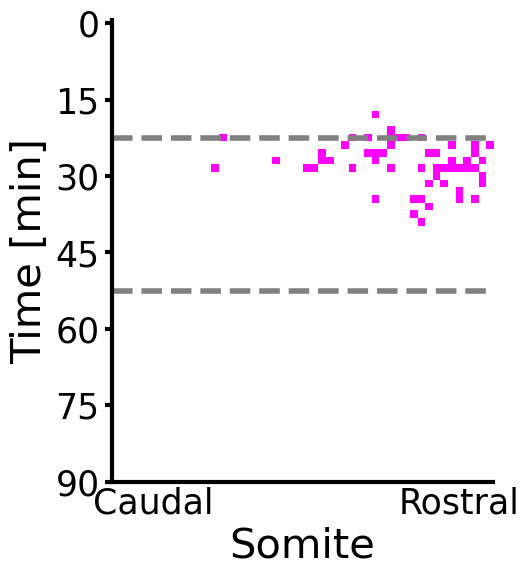

In [29]:
fig = plt.figure(figsize=[10,6])
grid1 = mesh_grid.T[0:60,::-1]
grid = grid1[::-1,:]
grid_max = np.nanmax(grid)
plt.axhline(15, color='grey', linestyle='dashed', linewidth=4)
plt.axhline(35, color='grey', linestyle='dashed', linewidth=4)

# plt.imshow(grid/grid_max, aspect=1.8, vmin=0.3, vmax=1, cmap='jet') # for N = 100
cmap_m = matplotlib.colors.ListedColormap(['white', 'magenta'])
cax = plt.imshow(grid/grid_max, aspect=1, cmap=cmap_m) # for N = 100
#cbar = plt.colorbar(cax, ticks=[0.2, 0.8])
#cbar.ax.set_yticklabels(['Mesp ON/OFF', 'Mest Onset'])  # vertically oriented colorbar

#cbar.ax.tick_params(labelsize=30)
#plt.draw()

#cbar.outline.set_color('black')
#cbar.outline.set_linewidth(3)

#plt.xticks(np.linspace(0,N,10), map(int,np.linspace(0,max_dist-min_dist,10)), fontsize=20)
plt.rcParams['xtick.major.pad']='20'
plt.xticks([5, N-5], ['Caudal', 'Rostral'], fontsize=25)
plt.yticks(np.arange(0,70,10), map(int,np.arange(0,70,10)*tr_min), fontsize=25)
plt.xlabel('Somite', fontsize=30)
plt.ylabel('Time [min]', fontsize=30)

ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'x', width=0, length=0)

plt.show()
fig.savefig('../Data/Figure 1/Figure 1F-I/Results/MespKymographs-MespOnset-Transposed.pdf', format='pdf', bbox_inches='tight')

## Her 1 Data

<a id='LoopK'></a>

For this analysis we backtracked cells from an entire somite in a Looping transgenic embryo. These cells were followed for around 100 minutes in order to capture the last peak times. 

If you want to go to the top of the notebook: [TOP](#top)

In [30]:
position = 2

In [31]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Figure 1/Figure 1F-I/Her 1 Data/Position%d_20191213.xml'%position

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../Data/Figure 1/Figure 1F-I/Her 1 Data/Position%d-somite'%position

# Path to the ROI zip
path_roi = '../Data/Figure 1/Figure 1F-I/Her 1 Data/RoiSet-Position%d-20191213.zip'%position

In [32]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('Image features from POSITION # %d'%(2))
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)
print(' ')

Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


In [33]:
# Function to obtain all the spots' information from the .csv file
spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks(path_csv, path_xml)

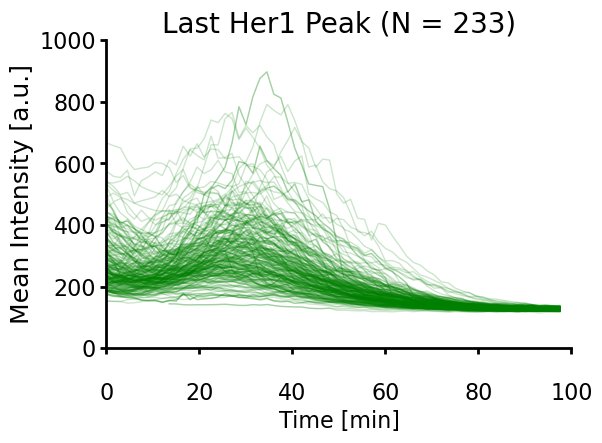

In [34]:
fig = plt.figure(figsize=[6,4])

tr = 90 # time resolution in seconds
tr_min = tr/60

# Cells that do not divide

for j in range(tracks.n_tracks_divs):
    plt.plot(tracks.spots_features['Frames'][j]*tr_min, tracks.spots_features['Mean1'][j], linewidth=1, color='green', alpha=0.2)


plt.title('Last Her1 Peak (N = %d)'%tracks.n_tracks_divs, fontsize = 20)
plt.xlabel('Time [min]', fontsize=16)
plt.xticks(np.arange(15,155,20), np.arange(15,155,20)-15, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Mean Intensity [a.u.]', fontsize=18)
plt.xlim([15,115])
plt.ylim([0,1000])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()

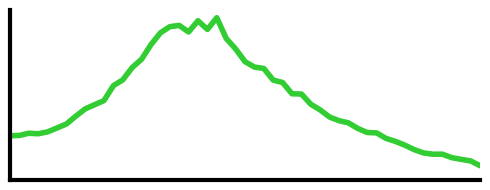

In [35]:
fig = plt.figure(figsize=[5,2])
j = 5
plt.plot(tracks.spots_features['Frames'][j]*tr_min, tracks.spots_features['Mean1'][j], color='limegreen', alpha=1, linewidth=4)

plt.xticks([])
plt.yticks([])
plt.xlim([15,90])
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1F-I/Results/Her1Somite-Traces-LastPeak-Example.pdf', bbox_inches='tight')

### Peak Detection

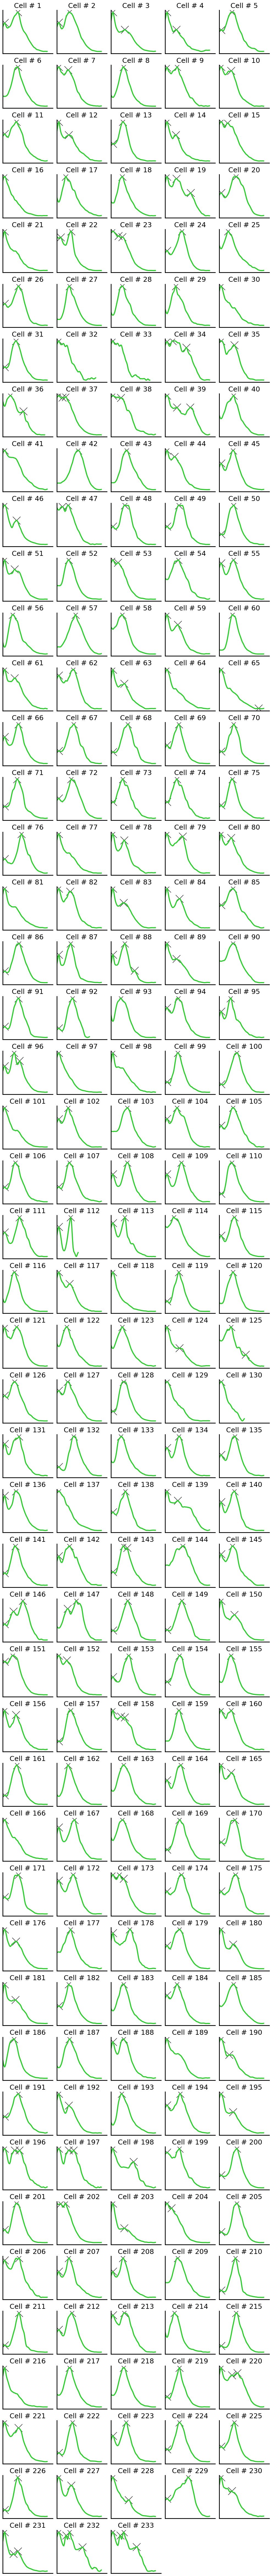

In [36]:
# Peak detection parameters

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 2 # For maxima
prominence_val_ = 4 # For minima

# Width
width_val = 1 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

# Number of cells
n_cells = tracks.n_tracks_divs

# Define the dimensions of the subplot
n_cols =  5
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
size_fig = n_rows*(10/n_cols)
fig = plt.figure(figsize=[10,size_fig])

# Save the Her 1 last peak
last_peak = []
# Save Mesp onset
onset_mesp = []

# Window size for lag correlation of mesp
window = 7
    

for j in range(n_cells):
    
    # HER 1 LAST PEAK
    track = tracks.spots_features['Mean1'][j]
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(track, window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val, \
                           prominence_val_, width_val, width_val_, analysis)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(track, window)
    
    # Safe the last peak
    if j == 64:
        last_peak.append(int(10+peaks.peaks[0]))
    else:
        last_peak.append(int(10+peaks.peaks[-1]))
    
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xk", markersize=20, linewidth=3);  
    plt.plot(y, color='limegreen', linewidth=3); 

    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,80])
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vivo/Results/Her1-Mesp-invivo-Smoothed.pdf', format='pdf', bbox_inches='tight')

In [37]:
# Percentage of cells doing last peak during S-1

total = len(last_peak)
s_1 = len(np.array(last_peak)[np.array(last_peak)<35])

(s_1/total)*100

73.39055793991416

### Kymograph

In [38]:
# Read all the ROIs
rois = read_roi_zip(path_roi)

# Number of timepoints
time_points = len(rois)

# Number of points in each segmented notochord line
notochord_points = 32

# Name of ROIs per time point
name_rois = list(rois.keys())

# Initialize where to save the coordinates
x_coords_not = np.zeros((time_points, notochord_points))
y_coords_not = np.zeros((time_points, notochord_points))

for j in range(len(rois)):

    # To know in which frame the analysis happened
    frame = rois[name_rois[j]]['position']-1 #['frame']-1

    x_coords_not[frame,:] = rois[name_rois[j]]['x']
    y_coords_not[frame,:] = rois[name_rois[j]]['y']

#### Apply Transformations

In [39]:
n_cells = tracks.n_tracks_divs

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((n_cells, fts.n_frames+1))*np.nan
last_peaks_save = np.zeros((n_cells, fts.n_frames+1))
    

# Save also the x,y positions
x_save = np.ones((n_cells, fts.n_frames+1))*np.nan
y_save = np.ones((n_cells, fts.n_frames+1))*np.nan
z_save = np.ones((n_cells, fts.n_frames+1))*np.nan

# For each track 
for i in range(n_cells):
    frames = tracks.spots_features['Frames'][i]
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames):
        tracks_save[i,val] = tracks.spots_features['Mean1'][i][j]
        x_save[i,val] = tracks.spots_features['X'][i][j]
        y_save[i,val] = tracks.spots_features['Y'][i][j]
        z_save[i,val] = tracks.spots_features['Z'][i][j]
     
    # Add a 1 when there is a peak
    lp_ind = last_peak[i]
    last_peaks_save[i,lp_ind] = 1

In [40]:
obj = untangle.parse(path_xml)

x_save_r = []
y_save_r = []
z_save_r = []

time_points = fts.n_frames+1 #np.max(tracks.spots_features['Frames'][1])

for j in range(n_cells):
    
    aux_x = []
    aux_y = []
    aux_z = []
    
    for i in range(0,(time_points)*fts.channels,fts.channels):
        
        # XYZ coordinates from mastodon
        xyz_coord = np.array([x_save[j][int(i/2)],y_save[j][int(i/2)],z_save[j][int(i/2)]]).reshape(-1,1)
    
        # Registration from .xml
        registration = np.array(obj.SpimData.ViewRegistrations.ViewRegistration[i].ViewTransform[0].affine.cdata.split(),dtype=float).reshape(3,4)
        
        # Rotation matrix
        R = registration[:,:3] 
        
        # Inverse of rotation matrix
        R_inv = np.linalg.inv(R)
        
        # Translation matrix
        T = registration[:,-1].reshape(-1,1)
        
        final = R_inv@(xyz_coord-T)
        
        # Save xyz de-registered coordinates
        aux_x.append(final[0][0])
        aux_y.append(final[1][0])
        aux_z.append(final[2][0])

    x_save_r.append(aux_x)
    y_save_r.append(aux_y)
    z_save_r.append(aux_z)

#### Equidistant points: to increase spatial resolution

In [41]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
n_points = 20 # Number of points to add 

for i in range(time_points):
    
    # Initial number of points from fiji
    x = x_coords_not[i].astype(int)
    y = y_coords_not[i].astype(int)
    
    x_aux = []
    y_aux = []
    
    for j in range(notochord_points-1):
        aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))
        
        # For each of the inserted points
        for k in range(len(aux)-1):
            x_aux.append(aux[k][0])
            y_aux.append(aux[k][1])
            
    x_not_equidist.append(x_aux)
    y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 300
Number of points per timepoint: 620


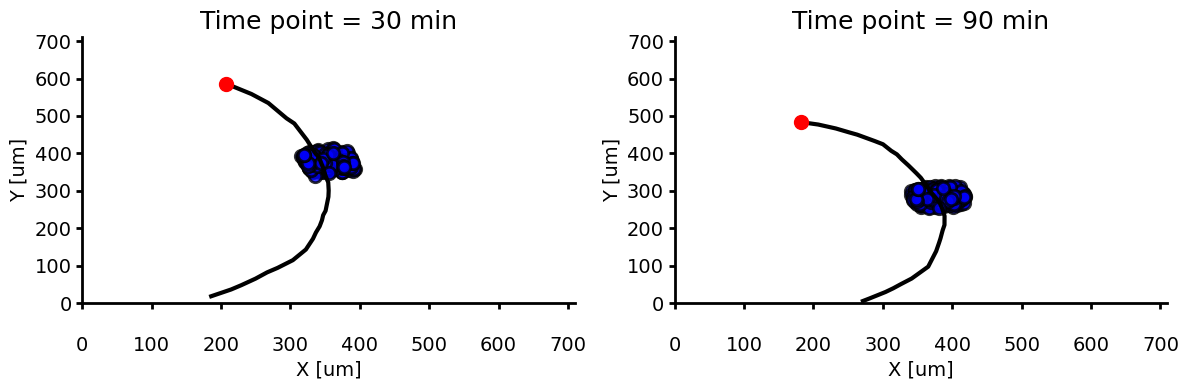

In [42]:
plt.figure(figsize=[12,4])
plt.subplot(121)
tp = 20
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.subplot(122)
tp = 60
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
     plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.tight_layout()
plt.show()

#### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [43]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return distance_to_ref

In [44]:
# Project the rest of the cells
proj_dist_all = []

# For each cell tracked
for i in range(n_cells):
    
    distance = []
    frames = tracks.spots_features['Frames'][i]
    # For each of the timepoints
    for j in frames:
        
        # Find the projected value
        distance.append(projectionNotochord(x_save_r[i][j], y_save_r[i][j],\
                                np.array(x_not_equidist[j])*fts.x_pixel, \
                                            np.array(y_not_equidist[j])*fts.x_pixel))

    proj_dist_all.append(distance)
    
# Because they all have different sizes, make them all have the same length for simplicity for later computations
proj_save = np.ones((n_cells, fts.n_frames+1))*np.nan

# For each track 
for i in range(n_cells):
    frames = tracks.spots_features['Frames'][i]
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames):
        proj_save[i,val] = proj_dist_all[i][j]

### Kymograph for the last Peak

In [45]:
position = []
intensity = []

for i in range(fts.n_frames):
    aux1 = []
    aux2 = []
    
    for j in range(n_cells):
        # For each timepoint, get all the cells in that timepoint: the distance of the projection
        # and the intensity for that position
        aux1.append(proj_save[j,i])
        aux2.append(last_peaks_save[j,i])
    
    # Organize the distances according to which is more posterior (e.g. smaller)
    inds = np.argsort(aux1)
    position.append(np.array(aux1)[inds])
    intensity.append(np.array(aux2)[inds])

#### Create the grid

In [46]:
min_dist = np.nanmin(position)
max_dist = np.nanmax(position)

N = 50
space = np.linspace(min_dist, max_dist, N)
time = np.arange(fts.n_frames)

mesh_grid = np.zeros((N, fts.n_frames))
mesh_grid_max = np.zeros((N, fts.n_frames))

for i in range(fts.n_frames):
    # If all the values in that timepoint are nan, then there are no cells tracked
    # for that timepoint, therefore continue
    if all(np.isnan(position[i])):
        continue
    else:
        # Find minima and maxima for each position
        d1 = np.nanmin(position[i])
        d2 = np.nanmax(position[i])
        
        # Number of points
        dist = np.linspace(d1, d2, N)
        sorted_vals = np.array(np.argsort(position[i]))[::-1]

        # Create a binning 
        sorted_vals_binned = list(map(int,np.linspace(0,len(sorted_vals),N)))

        for j in range(N-1):
            ind_dist = sorted_vals[sorted_vals_binned[j]:sorted_vals_binned[j+1]]
            aux1 = np.mean(intensity[i][ind_dist])
            aux2 = np.max(intensity[i][ind_dist])

            # Find the closest values in the grid to enter this position
            ind_min = np.argmin((position[i][j]-space)**2)
            mesh_grid[j, i] = aux1
            mesh_grid_max[j, i] = aux2

In [47]:
# Binarize the grid: we only want to have 1s whereever there are peaks

mesh_grid[mesh_grid>0]=1

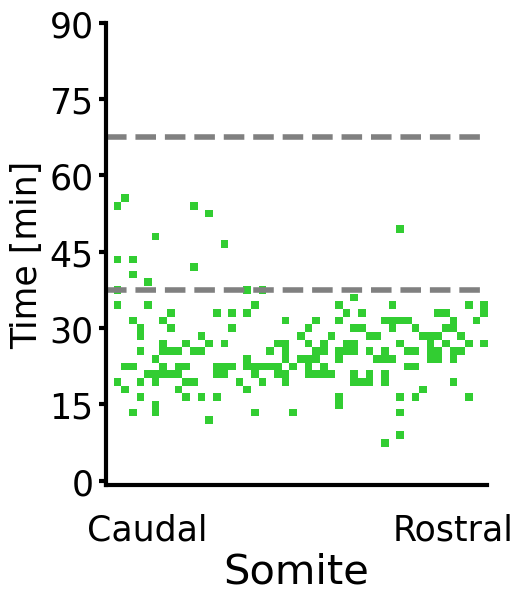

In [48]:
fig = plt.figure(figsize=[10,6])
grid = mesh_grid.T[15:75,::-1] # Anterior is right and posterior is left
#grid = grid1[::-1, :]

grid_max = np.nanmax(grid)
plt.axhline(25, color='grey', linestyle='dashed', linewidth=4)
plt.axhline(45, color='grey', linestyle='dashed', linewidth=4)

# plt.imshow(grid/grid_max, aspect=1.8, vmin=0.3, vmax=1, cmap='jet') # for N = 100
cmap_m = matplotlib.colors.ListedColormap(['white', 'limegreen'])
cax = plt.imshow(grid/grid_max, aspect=1, cmap=cmap_m) # for N = 100


#plt.xticks(np.linspace(0,N,10), map(int,np.linspace(0,max_dist-min_dist,10)), fontsize=20)

plt.xticks([5, N-5], ['Caudal', 'Rostral'], fontsize=25)
plt.rcParams['xtick.major.pad']='15'
plt.yticks(np.arange(0,70,10), map(int,np.arange(0,70,10)*tr_min), fontsize=25)
plt.xlabel('Somite', fontsize=30)
plt.ylabel('Time [min]', fontsize=25)

ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'x', width=0, length=0)
plt.gca().invert_yaxis()

plt.show()
fig.savefig('../Data/Figure 1/Figure 1F-I/Results/Her1Kymographs-LastPeak-Transposed.pdf', format='pdf', bbox_inches='tight')